##Alunos:
*   Fabio Cardoso - fc2@cesar.school
*   Andréa Fonseca - asf4@cesar.school

##Dataset
https://www.kaggle.com/datasets/juniorbueno/neural-networks-homer-and-bart-classification

## Importação das bibliotecas

In [ ]:
from os.path import exists
import torch
import zipfile

In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

##Importando o dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = '/content/gdrive/My Drive/Bart_Homer.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
data_dir_train = '/content/Bart_Homer/Treinamento'
data_dir_test = '/content/Bart_Homer/Teste'

##Definição da Rede Neural

In [ ]:
class NetBartHomer(nn.Module):
    def __init__(self):
        super(NetBartHomer, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(224 * 224 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
      x = x.view(-1, 224 * 224 * 3) # Reshape to match the expected input size
      x = self.dense(x)
      output = F.log_softmax(x, dim=1)
      return output

model = NetBartHomer()

##Função para treinamento do modelo

In [ ]:
def train(log_interval, dry_run, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target[:output.size(0)])
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

##Função para o teste do modelo

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

##Função do modelo e avaliação

In [ ]:
use_cuda = torch.cuda.is_available()

torch.manual_seed(14)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 5}
test_kwargs = {'batch_size': 25}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform_train=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=7, translate=(0, 0.07), shear=0.2, scale=(1, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

transform_test = transforms.Compose(
    [
     transforms.Resize([224,224]),
     transforms.ToTensor()
    ]
)

dataset1 = train_dataset = datasets.ImageFolder(data_dir_train, transform=transform_train)
dataset2 = test_dataset = datasets.ImageFolder(data_dir_test, transform=transform_test)

train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = NetBartHomer().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.1)

epochs = 20
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

for epoch in range(1, epochs + 1):
    train(10, False, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

torch.save(model.state_dict(), "homer_bart.pt")

Train Epoch: 1 [0/202 (0%)]	Loss: 0.697115
Train Epoch: 1 [50/202 (24%)]	Loss: 0.024825
Train Epoch: 1 [100/202 (49%)]	Loss: 1.891867
Train Epoch: 1 [150/202 (73%)]	Loss: 1.543227
Train Epoch: 1 [80/202 (98%)]	Loss: 1.522758

Test set: Average loss: 0.8405, Accuracy: 40/67 (60%)

Train Epoch: 2 [0/202 (0%)]	Loss: 1.723411
Train Epoch: 2 [50/202 (24%)]	Loss: 0.661287
Train Epoch: 2 [100/202 (49%)]	Loss: 0.449178
Train Epoch: 2 [150/202 (73%)]	Loss: 0.656151
Train Epoch: 2 [80/202 (98%)]	Loss: 0.316702

Test set: Average loss: 0.6605, Accuracy: 40/67 (60%)

Train Epoch: 3 [0/202 (0%)]	Loss: 0.149667
Train Epoch: 3 [50/202 (24%)]	Loss: 0.583143
Train Epoch: 3 [100/202 (49%)]	Loss: 0.713685
Train Epoch: 3 [150/202 (73%)]	Loss: 0.696687
Train Epoch: 3 [80/202 (98%)]	Loss: 0.156514

Test set: Average loss: 0.6518, Accuracy: 40/67 (60%)

Train Epoch: 4 [0/202 (0%)]	Loss: 0.831799
Train Epoch: 4 [50/202 (24%)]	Loss: 0.619585
Train Epoch: 4 [100/202 (49%)]	Loss: 0.563846
Train Epoch: 4 [150/202

##Visualização dos Dados

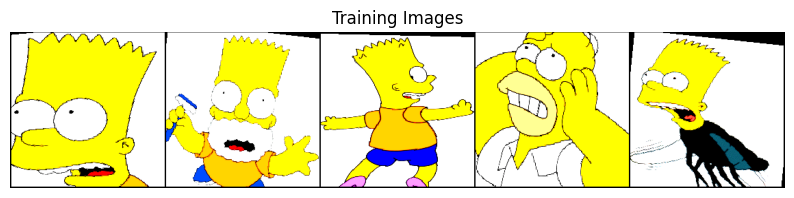

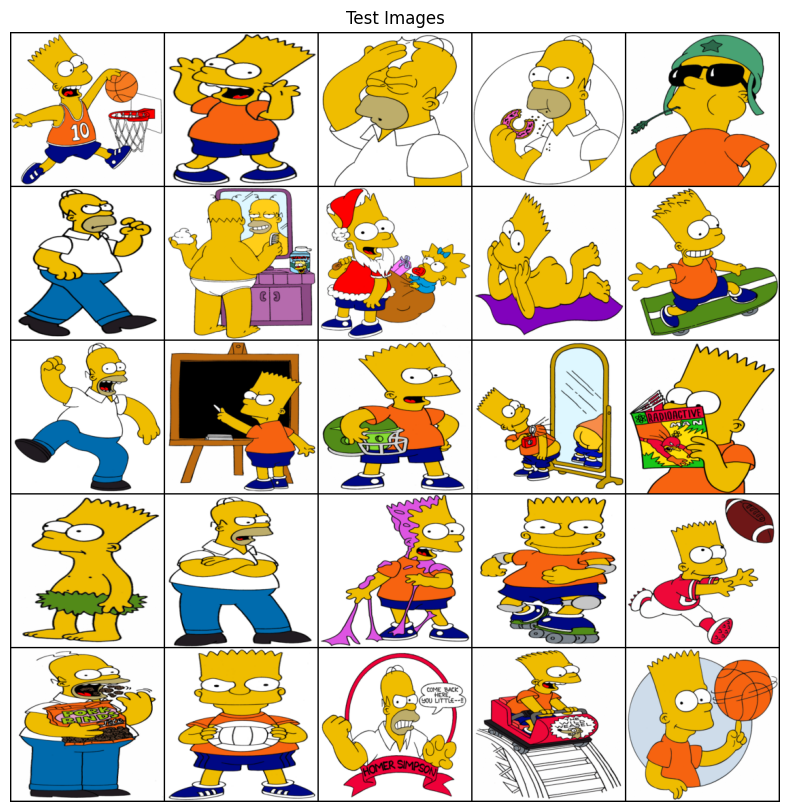

<ipython-input-33-ab9b294827d2>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(class_counts))), y=class_counts, palette="viridis")


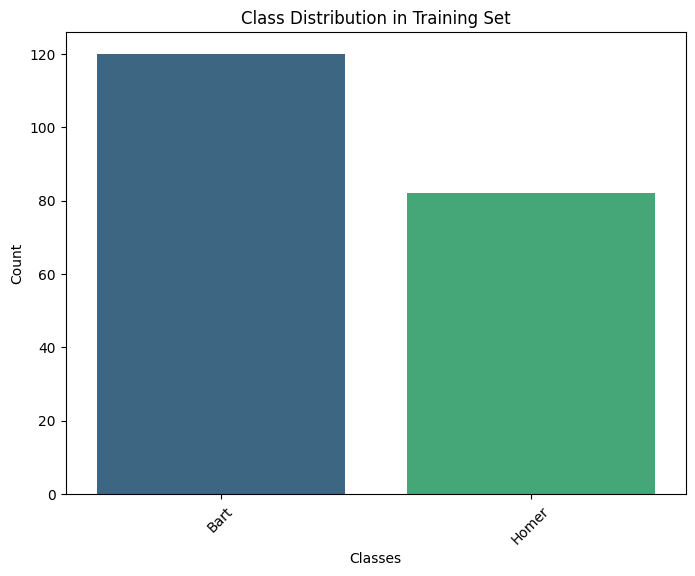

<ipython-input-33-ab9b294827d2>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(class_counts))), y=class_counts, palette="viridis")


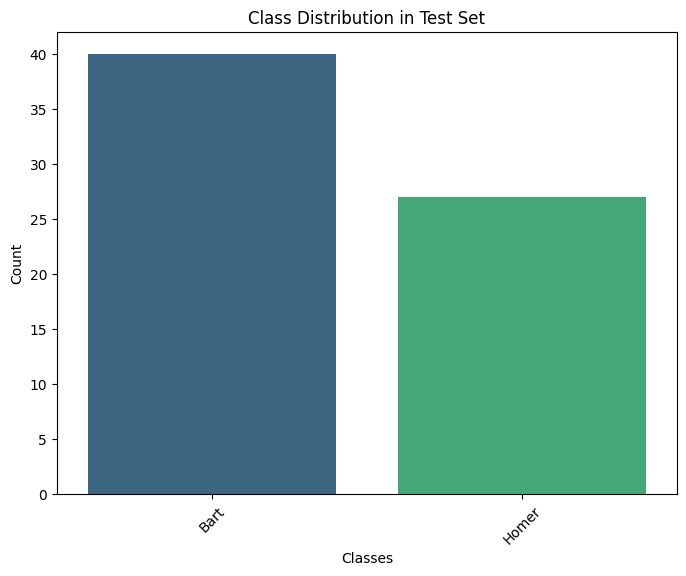

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import numpy as np

# Função para mostrar uma grade de imagens
def show_images(images, labels, title=None):
    plt.figure(figsize=(10, 10))
    grid_img = make_grid(images, nrow=5)
    npimg = grid_img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Função para mostrar algumas imagens de treinamento e teste
def visualize_samples(train_loader, test_loader, class_names):
    # Mostrar algumas imagens de treinamento
    dataiter = iter(train_loader)
    images, labels = next(dataiter)  # Corrigido para usar next()
    show_images(images, labels, title="Training Images")

    # Mostrar algumas imagens de teste
    dataiter = iter(test_loader)
    images, labels = next(dataiter)  # Corrigido para usar next()
    show_images(images, labels, title="Test Images")

# Função para plotar a distribuição das classes
def plot_class_distribution(dataset, title):
    class_counts = [0] * len(dataset.classes)
    for _, label in dataset:
        class_counts[label] += 1

    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(range(len(class_counts))), y=class_counts, palette="viridis")
    plt.xticks(list(range(len(class_counts))), dataset.classes, rotation=45)
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

# Visualizar algumas amostras dos dados de treinamento e teste
visualize_samples(train_loader, test_loader, dataset1.classes)

# Plotar a distribuição das classes para os conjuntos de treinamento e teste
plot_class_distribution(dataset1, "Class Distribution in Training Set")
plot_class_distribution(dataset2, "Class Distribution in Test Set")


##Visualização do modelo (Perda, acurácia e matriz de confusão)

Epoch [1/20], Train Loss: 0.8865, Train Accuracy: 51.49%, Test Loss: 0.6696, Test Accuracy: 59.70%
Epoch [2/20], Train Loss: 0.3610, Train Accuracy: 54.95%, Test Loss: 0.6808, Test Accuracy: 59.70%
Epoch [3/20], Train Loss: 0.5305, Train Accuracy: 60.89%, Test Loss: 0.6558, Test Accuracy: 59.70%
Epoch [4/20], Train Loss: 0.5680, Train Accuracy: 62.87%, Test Loss: 0.7414, Test Accuracy: 40.30%
Epoch [5/20], Train Loss: 0.5442, Train Accuracy: 68.32%, Test Loss: 0.6344, Test Accuracy: 76.12%
Epoch [6/20], Train Loss: 0.1874, Train Accuracy: 73.27%, Test Loss: 0.6253, Test Accuracy: 77.61%
Epoch [7/20], Train Loss: 0.7141, Train Accuracy: 75.25%, Test Loss: 0.6293, Test Accuracy: 67.16%
Epoch [8/20], Train Loss: 0.1827, Train Accuracy: 74.26%, Test Loss: 0.6225, Test Accuracy: 67.16%
Epoch [9/20], Train Loss: 0.2648, Train Accuracy: 75.25%, Test Loss: 0.6136, Test Accuracy: 74.63%
Epoch [10/20], Train Loss: 0.1578, Train Accuracy: 75.25%, Test Loss: 0.6167, Test Accuracy: 73.13%
Epoch [11

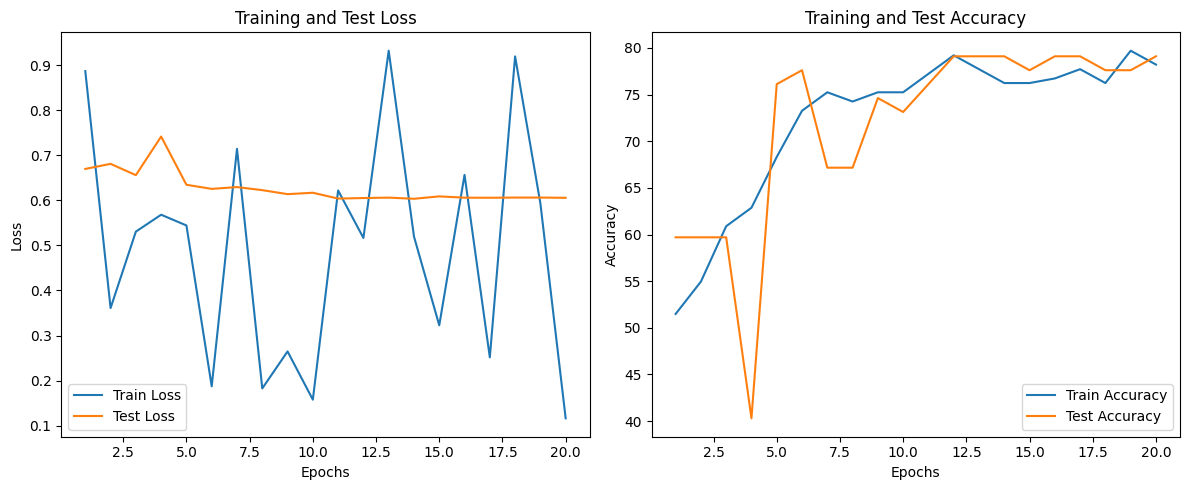

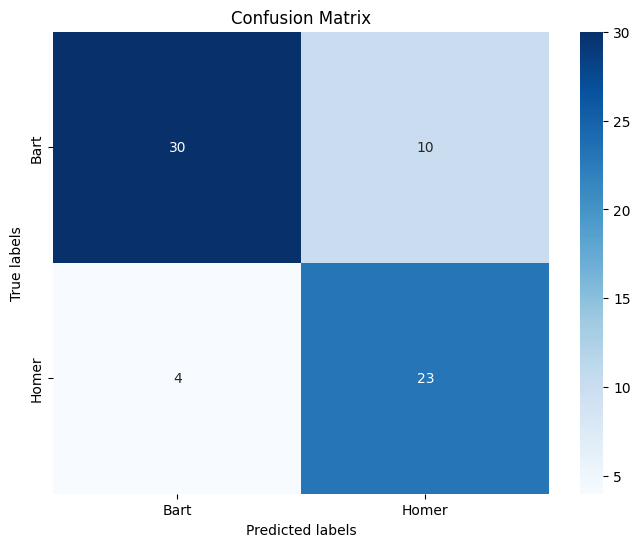

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision.utils import make_grid
import numpy as np
import itertools

# Função para mostrar uma grade de imagens
def show_images(images, labels, title=None):
    plt.figure(figsize=(10, 10))
    grid_img = make_grid(images, nrow=5)
    npimg = grid_img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Função para mostrar algumas imagens de treinamento e teste
def visualize_samples(train_loader, test_loader, class_names):
    # Mostrar algumas imagens de treinamento
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    show_images(images, labels, title="Training Images")

    # Mostrar algumas imagens de teste
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    show_images(images, labels, title="Test Images")

# Função para plotar a distribuição das classes
def plot_class_distribution(dataset, title):
    class_counts = [0] * len(dataset.classes)
    for _, label in dataset:
        class_counts[label] += 1

    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(range(len(class_counts))), y=class_counts, palette="viridis")
    plt.xticks(list(range(len(class_counts))), dataset.classes, rotation=45)
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

# Função para treinar o modelo e plotar as curvas de perda e acurácia
def train_and_plot(train_loader, test_loader, model, optimizer, scheduler, device, epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, epochs + 1):
        # Treinamento
        model.train()
        correct_train = 0
        total_train = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            # Estatísticas de treinamento
            pred_train = output.argmax(dim=1, keepdim=True)
            correct_train += pred_train.eq(target.view_as(pred_train)).sum().item()
            total_train += data.size(0)

        train_loss = loss.item()
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Avaliação no conjunto de teste
        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                pred_test = output.argmax(dim=1, keepdim=True)
                correct_test += pred_test.eq(target.view_as(pred_test)).sum().item()
                total_test += data.size(0)

                all_preds.extend(pred_test.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())

        test_loss /= len(test_loader.dataset)
        test_accuracy = 100. * correct_test / total_test
        val_losses.append(test_loss)
        val_accuracies.append(test_accuracy)

        # Ajustar o scheduler
        scheduler.step()

        # Imprimir progresso
        print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Plotar gráficos de perda e acurácia
    plt.figure(figsize=(12, 5))

    # Plotar perda
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()

    # Plotar acurácia
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Gerar e plotar a matriz de confusão
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset1.classes, yticklabels=dataset1.classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Definição de hiperparâmetros e carregamento de dados
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20
model = NetBartHomer().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

# Treinamento do modelo e plotagem dos gráficos de perda e acurácia
train_and_plot(train_loader, test_loader, model, optimizer, scheduler, device, epochs)


##Conclusão


Durante as 20 épocas de treinamento, observamos uma tendência de diminuição na perda tanto para o conjunto de treinamento quanto para o conjunto de teste. Isso sugere que o modelo está aprendendo efetivamente com os dados ao longo do tempo.

A acurácia do conjunto de treinamento aumentou de aproximadamente 50% na primeira época para cerca de 79.00% na última época. Similarmente, a acurácia do conjunto de teste variou de 59.00% na primeira época para 79.10% na última época.

Não parece haver overfitting significativo, já que não há uma grande diferença entre a acurácia do treinamento e a acurácia do teste. Ambas as curvas estão evoluindo de forma consistente e não há sinais de que o modelo esteja memorizando os dados de treinamento.

Também não há indicações claras de underfitting, pois a acurácia do teste está melhorando conforme o modelo aprende com os dados.

As métricas de treinamento e teste estão convergindo para valores semelhantes ao longo das épocas, indicando que o modelo está sendo treinado de maneira robusta e estável.

Com base nos resultados obtidos, o modelo parece estar bem ajustado aos dados de treinamento e é capaz de generalizar bem para novos dados de teste. A análise das curvas de perda, acurácia e a comparação entre as métricas de treinamento e teste sugerem que o modelo está atingindo um desempenho satisfatório sem sinais significativos de overfitting ou underfitting.








